# Auxiliar 14 - Preparación Tarea 3
El Ministerio de Transportes de España quiere estudiar los precios que se están cobrando en los tickets para viajar en sus trenes de alta velocidad. Esto con el fin de supervisar que los precios estén acorde a lo establecido reglamentariamente, y también para tomar medidas con el fin de mejorar el servicio para los clientes.

Bajo este contexto, se le pide analizar los datos transaccionales de estos viajes contenidos en un repositorio digital (https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv), guiándose de las siguientes instrucciones:

## Parte 1
Debido a la alta cantidad de datos, para efectos de este análisis su jefatura le recomienda trabajar con una muestra que represente el 1% de estos. Además, le informa que lo importante de este estudio es el precio de los tickets y sospechan que este pueda estar relacionado al tipo de tarifa, así que de haber precios incompletos en sus datos, imputar un valor que tenga que ver con la variable `fare`. Así que cargue los datos, extraiga la muestra, revise si hay valores nulos en el atributo de precio y reemplace estos valores con algún valor que estime conveniente. 

Cargamos las librerías necesarias.

In [ ]:
conda install m2w64-toolchain

In [2]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
import pandas as pd

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Leemos los datos y muestreamos un 1% de estos.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv')
#data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac=0.01, random_state=99)
data.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
4738,2019-04-17 08:03:35,VALENCIA,MADRID,2019-05-21 08:00:00,2019-05-21 09:47:00,AVE,33.65,Turista,Promo
8722,2019-05-09 07:12:41,MADRID,BARCELONA,2019-05-25 08:30:00,2019-05-25 11:15:00,AVE,85.10,Turista,Promo
13185,2019-04-24 11:21:26,MADRID,VALENCIA,2019-05-22 17:40:00,2019-05-22 19:20:00,AVE,51.15,Turista,Promo


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 4738 to 9733
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   insert_date  258 non-null    object 
 1   origin       258 non-null    object 
 2   destination  258 non-null    object 
 3   start_date   258 non-null    object 
 4   end_date     258 non-null    object 
 5   train_type   258 non-null    object 
 6   price        233 non-null    float64
 7   train_class  258 non-null    object 
 8   fare         258 non-null    object 
dtypes: float64(1), object(8)
memory usage: 20.2+ KB


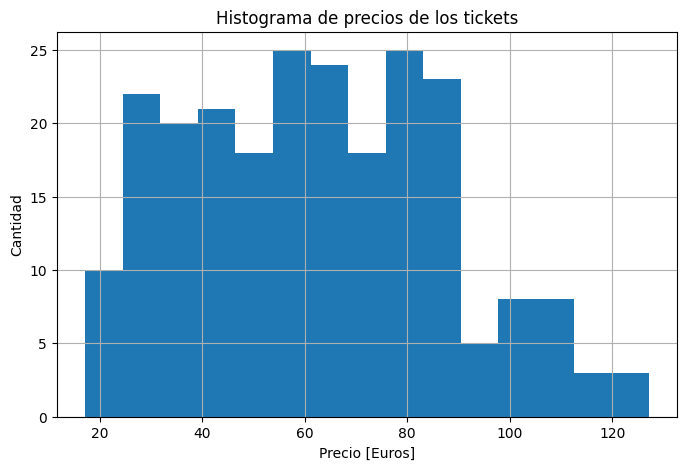

In [5]:
chart = data["price"].hist(bins = 15, figsize=(8, 5))
chart.set_title("Histograma de precios de los tickets")
chart.set_xlabel("Precio [Euros]")
chart.set_ylabel("Cantidad")
plt.show()

c:\Users\mvarasg\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


([<matplotlib.axis.YTick at 0x191c3bbf290>], [Text(0, 0, '0')])

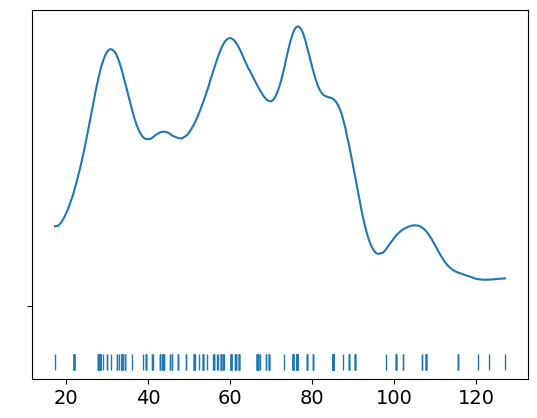

In [6]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0)

In [7]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.096899
train_class    0.000000
fare           0.000000
dtype: float64

Imputamos los valores faltantes en el precio por la media del tipo de tarifa al que corresponda.

In [8]:
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0)

TypeError: Could not convert 2019-04-19 16:07:222019-04-23 02:10:492019-04-30 09:02:172019-04-29 07:29:322019-05-08 21:29:562019-04-28 15:20:592019-04-17 20:13:062019-04-15 22:09:522019-04-20 01:22:342019-04-17 03:28:372019-04-14 17:17:552019-04-25 01:08:582019-04-14 19:33:292019-04-20 09:12:192019-04-13 18:09:23 to numeric

## Parte 2
Le indican que asuma que los precios distribuyen $Normal(\mu, \sigma^2)$, mientras que el parámetro $\mu$ tiene una distribución $Uniforme(0,200)$ y $\sigma$ distribuye $HalfNormal(10)$. Plantee la forma de la posterior.

Tenemos las siguientes dependencias:

\begin{align*}
y & \sim Normal(\mu, \sigma^2) \rightarrow a(\mu, \sigma^2) \text{ (verosimilitud)} \\
\mu & \sim Uniforme(0,200) \rightarrow b(0, 200)\\
\sigma & \sim HalfNormal(10) \rightarrow c(10)
\end{align*}

De esta manera, la posterior tiene la siguiente forma:

\begin{align*}
p(\mu, \sigma|y) & \propto p(y|\mu, \sigma^2) p(\mu, \sigma) \\
& \propto p(y|\mu, \sigma^2) p(\mu) p(\sigma) \\
& \propto a(\mu, \sigma^2) b(0, 200) c(10)
\end{align*}

## Parte 3
Con la librería $pymc$ extraiga muestras de dicha posterior y visualice los resultados sobre $\mu$ y $\sigma$ con el paquete $arviz$.

In [9]:
with pm.Model() as model_g:
    mean = pm.Uniform('mean', lower=0, upper=200)

    sd = pm.HalfNormal('sd', sigma=10)

    y = pm.Normal('y', mu=mean, sigma=sd, observed=data['price'])

    trace_g = pm.sample(1000)

c:\Users\mvarasg\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymc\model.py:1360: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, sd, y_unobserved]


ValueError: Not enough samples to build a trace.

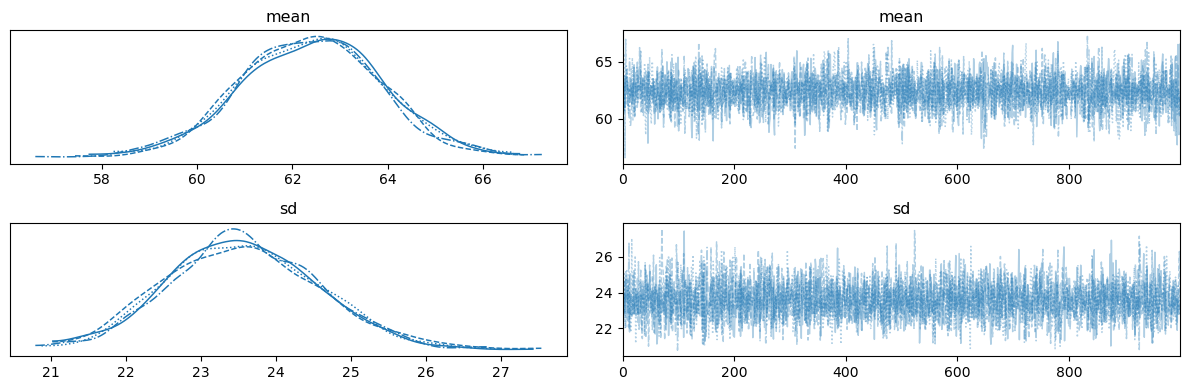

In [ ]:
az.plot_trace(trace_g)
plt.tight_layout()
plt.show()

array([[<Axes: >, None],
       [<Axes: xlabel='mean', ylabel='sd'>, <Axes: >]], dtype=object)

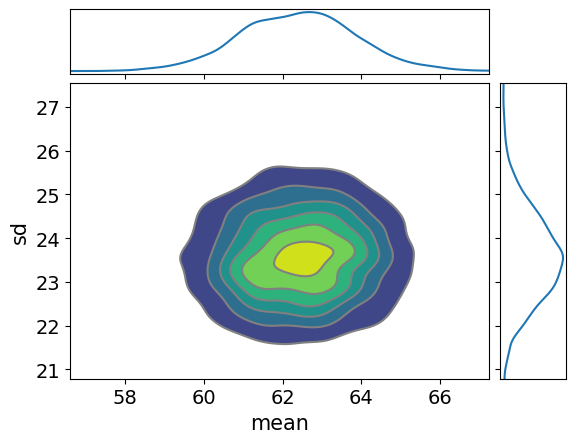

In [ ]:
az.plot_pair(trace_g, kind='kde', marginals=True)

In [ ]:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,62.387,1.475,59.544,65.126,0.023,0.017,3961.0,2806.0,1.0
sd,23.575,1.014,21.807,25.536,0.016,0.011,4134.0,2813.0,1.0


array([<Axes: title={'center': 'mean'}>, <Axes: title={'center': 'sd'}>],
      dtype=object)

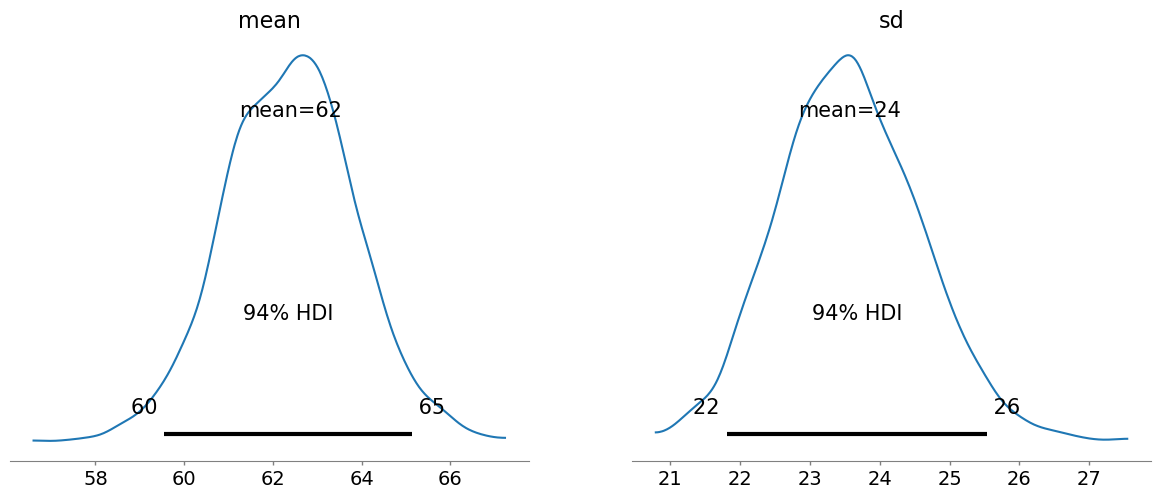

In [ ]:
az.plot_posterior(trace_g)

## Parte 4
Como antes se adelantaba, se cree que hay una relación entre los precios y el tipo de tarifa que ofrecen las estaciones, dada por la columna `fare` del dataset. Entonces, asumiendo que la media de cada grupo distribuye $Normal(0, 10^2)$, obtenga las estimaciones de los parámetros para cada grupo.

In [ ]:
price = data['price'].values
# Columna fare como variable categorica
idx = pd.Categorical(data['fare'],
                     categories=['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa', 'Individual-Flexible']).codes
# Cantidad de tipos de fare en los datos
groups = len(np.unique(idx))
groups

4

In [ ]:
with pm.Model() as comparing_groups:
    mu = pm.Normal('mean', mu=0, sigma=10, shape=groups)
    sd = pm.HalfNormal('sd', sigma=10, shape=groups)

    y = pm.Normal('y', mu=mu[idx], sigma=sd[idx], observed=price)

    trace_groups = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, sd]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 66 seconds.


In [ ]:
fares_gaussian = az.summary(trace_groups)
fares_gaussian

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean[0],71.432,2.498,66.727,76.038,0.016,0.012,23343.0,14795.0,1.0
mean[1],60.288,1.739,57.102,63.604,0.011,0.008,25758.0,15221.0,1.0
mean[2],35.865,2.052,31.796,39.374,0.019,0.013,15729.0,9124.0,1.0
mean[3],28.995,1.118,26.889,31.105,0.008,0.006,19770.0,12850.0,1.0
sd[0],18.297,1.765,15.079,21.613,0.012,0.009,22953.0,13926.0,1.0
sd[1],23.011,1.209,20.644,25.178,0.008,0.005,25098.0,15165.0,1.0
sd[2],5.030,1.812,2.439,8.305,0.017,0.013,15356.0,10620.0,1.0
sd[3],4.218,0.890,2.738,5.877,0.007,0.005,20784.0,13341.0,1.0


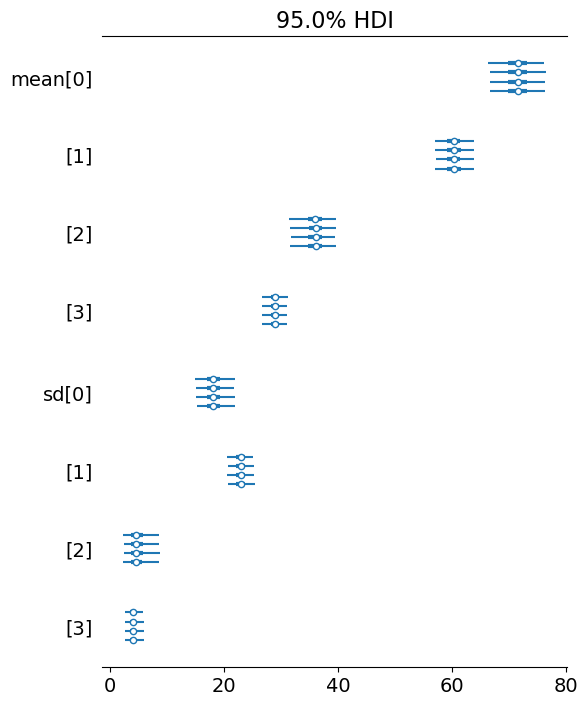

In [ ]:
az.plot_forest(trace_groups, hdi_prob=0.95)
plt.show()

Fuente del problema: https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501
